## Observations and Insights 

In [54]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata_df = pd.read_csv(mouse_metadata_path)
study_results_df = pd.read_csv(study_results_path)

# Combine the data into a single dataset
df = pd.merge(mouse_metadata_df, study_results_df, how="left", on="Mouse ID")

# Display the data table for preview
df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [55]:
# Check the number of mice.
num_mice = len(df["Mouse ID"].unique())
num_mice

249

In [56]:
# Find any duplicate rows with the same Mouse IDs and Timepoints. 
dup_mice = df[df.duplicated(["Mouse ID", "Timepoint"], keep=False)]

# Check for number of different mice with duplicates
len(dup_mice["Mouse ID"].unique())

1

In [57]:
# Drop any duplicate rows
df = df.drop(df.loc[df["Mouse ID"]==dup_mice.iloc[1,0]].index)

In [58]:
# Recheck the number of mice
num_mice = len(df["Mouse ID"].unique())
num_mice

248

## Summary Statistics

In [106]:
# Generate a summary statistics table of mean, median, variance, 
# standard deviation, and SEM of the tumor volume for each regimen.
drug_gb = df.groupby("Drug Regimen")

summary = pd.DataFrame({
    "Mean": drug_gb["Tumor Volume (mm3)"].mean(),
    "Median": drug_gb["Tumor Volume (mm3)"].median(),
    "Variance": drug_gb["Tumor Volume (mm3)"].var(),
    "Standard Deviation": drug_gb["Tumor Volume (mm3)"].std(),
    "SEM": drug_gb["Tumor Volume (mm3)"].sem()
})
summary.style.set_caption("Tumor Volume Statistics by Regimen")

,Mean,Median,Variance,Standard Deviation,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

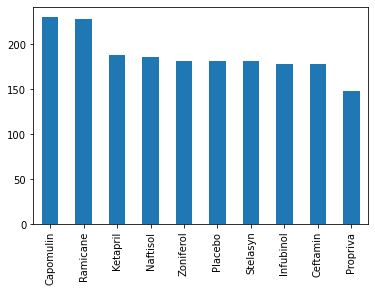

In [60]:
# Generate a bar plot showing the total number of datapoints for each drug regimen using pandas.
# There should be a single bar per regimen
df["Drug Regimen"].value_counts().plot.bar()


([<matplotlib.axis.XTick at 0x1a9911c77f0>,
 [Text(0, 0, 'Ramicane'),
  Text(0, 0, 'Capomulin'),
  Text(0, 0, 'Infubinol'),
  Text(0, 0, 'Placebo'),
  Text(0, 0, 'Ceftamin'),
  Text(0, 0, 'Stelasyn'),
  Text(0, 0, 'Zoniferol'),
  Text(0, 0, 'Ketapril'),
  Text(0, 0, 'Propriva'),
  Text(0, 0, 'Naftisol')])

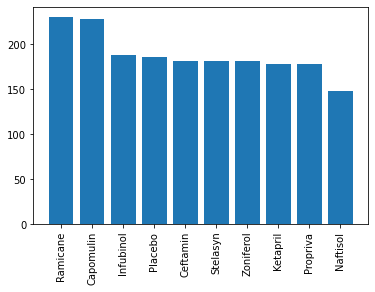

In [61]:
# General identical bar plot using pyplot instead of pandas.
x_axis = df["Drug Regimen"].unique()
tick_locations = [value for value in x_axis]

plt.bar(x_axis, df["Drug Regimen"].value_counts(), align="center")
plt.xticks(tick_locations, df["Drug Regimen"].unique(), rotation="vertical")

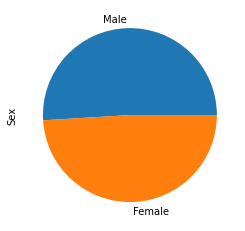

In [62]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
df["Sex"].value_counts().plot.pie()


([<matplotlib.patches.Wedge at 0x1a992261c88>,
 [Text(-0.03308201408261547, 1.0995024239828841, ''),
  Text(0.033082014082615095, -1.0995024239828841, '')])

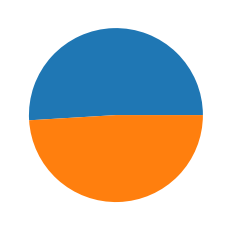

In [63]:
# Generate identical pie plot using pyplot
plt.pie(df["Sex"].value_counts())


## Quartiles, Outliers and Boxplots

In [64]:
##### Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# HINT: Not all mice lived until timepoint 45
# Start by getting the last (greatest) timepoint for each mouse
mouse_gb = df.groupby("Mouse ID")["Timepoint"].transform(max) == df["Timepoint"]

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
df["Final Tumor Volume"] = df[mouse_gb]["Tumor Volume (mm3)"]

Calculate the quartiles and IQR and quantitatively determine if there are any potential outliers across all four treatment regimens.

In [105]:
# Calculate quartiles, IQR, and identify potential outliers for each regimen.

# Put treatments into a list for for loop (and later for plot labels)
regimens = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]


fin_tumor_vol = {
    regimens[0]: df["Final Tumor Volume"].loc[(df["Drug Regimen"] == regimens[0]) & df["Final Tumor Volume"]].tolist(),
    regimens[1]: df["Final Tumor Volume"].loc[(df["Drug Regimen"] == regimens[1]) & df["Final Tumor Volume"]].tolist(),
    regimens[2]: df["Final Tumor Volume"].loc[(df["Drug Regimen"] == regimens[2]) & df["Final Tumor Volume"]].tolist(),
    regimens[3]: df["Final Tumor Volume"].loc[(df["Drug Regimen"] == regimens[3]) & df["Final Tumor Volume"]].tolist()
}

#cap_list = df["Final Tumor Volume"].loc[(df["Drug Regimen"] == regimens[0]) & df["Final Tumor Volume"]].tolist()
#cap_list
# Calculate the IQR and quantitatively determine if there are any potential outliers. 

for key in fin_tumor_vol.keys():
    lowerq = np.quantile(fin_tumor_vol[key], .25)
    upperq = np.quantile(fin_tumor_vol[key], .75)
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"The IQR for {key} is {round(iqr,4)}. ")
    print(f"Values below {round(lower_bound,4)} could be outliers.")
    print(f"Values above {round(upper_bound,4)} could be outliers.")
    if np.any(fin_tumor_vol[key] > upper_bound) | np.any(fin_tumor_vol[key] < lower_bound):
        print(f"**{key} could have outliers.**")
    

The IQR for Capomulin is 7.7819. 
Values below 20.7046 could be outliers.
Values above 51.832 could be outliers.
The IQR for Ramicane is 9.0985. 
Values below 17.9127 could be outliers.
Values above 54.3068 could be outliers.
The IQR for Infubinol is 11.4771. 
Values below 36.8329 could be outliers.
Values above 82.7414 could be outliers.
**Infubinol could have outliers.**
The IQR for Ceftamin is 15.5778. 
Values below 25.3554 could be outliers.
Values above 87.6665 could be outliers.


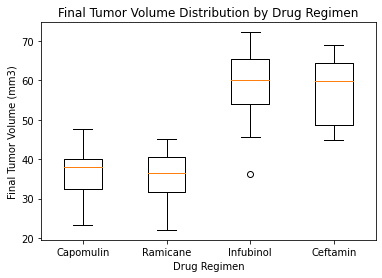

In [100]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
# There should be a single chart with four box plots inside it.
labels, data = fin_tumor_vol.keys(), fin_tumor_vol.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel("Drug Regimen")
plt.ylabel("Final Tumor Volume (mm3)")
plt.title("Final Tumor Volume Distribution by Drug Regimen")
plt.show()

## Line and Scatter Plots

In [ ]:
# Generate a line plot of tumor volume vs. time point for a single mouse 
# treated with Capomulin


In [ ]:
# Generate a scatter plot of average tumor volume vs. mouse weight 
# for all mice in the Capomulin regimen


## Correlation and Regression

In [ ]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen


# Observations and Insights